# Training

In [2]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd

In [3]:
import torch

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [5]:
#getting path for the dataset
path2 = os.path.join(os.getcwd(), "Logo_classif3")

In [6]:
#applying a transform on all images and building the dataset
transform = transforms.Compose([
transforms.Resize((128, 128)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)
])

logos = ImageFolder(path2, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


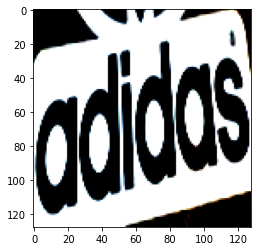

In [7]:
plt.imshow(logos[152][0].permute(1, 2, 0))

In [8]:
logos.classes

['ASUS',
 'Adidas SB',
 'Armani',
 'Asics',
 'BEATS BY DRE',
 'BMW',
 'BOSCH',
 'BOSS',
 'Balenciaga',
 'BenQ',
 'Bentley',
 'Calvin Klein',
 'Chevrolet',
 'Converse',
 'Corona',
 'Dacia',
 'Everlast',
 'Guess',
 'Hot Wheels',
 'Hugo Boss',
 'Hyundai',
 'IBM',
 'LAVAZZA',
 'Lamborghini',
 'Logitech',
 "McDonald's",
 'None',
 'coca cola',
 'iPhone',
 'kia da',
 'lacoste',
 'lego mindstorms',
 'lexus',
 'louis vuitton',
 'nestle',
 'new balance',
 'nivea',
 'opel',
 'pepsi',
 'polo ralph lauren',
 'prada',
 'the north face',
 'tommy hilfiger',
 'toyota',
 'uber',
 'versace',
 'xiaomi',
 'zara']

In [9]:
#checking length of dataset
len(logos)

4721

In [10]:
#checking how many classes are present in the dataset
len(logos.classes)

48

In [11]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

In [14]:
#create a dataset class
class Logos(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample = {"pic": self.X[index][0], "label": self.X[index][1]}
        return sample

In [15]:
full_data = Logos(logos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


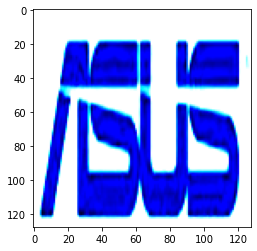

In [16]:
#checking if __getitem__() works
plt.imshow(full_data[0]["pic"].permute(1, 2, 0))

In [17]:
#calculating train and test size, train size is about 80% of the whole dataset
train_size = int(0.8*len(logos))
test_size = len(logos) - train_size
train_size, test_size

(3776, 945)

In [18]:
#splitting whole dataset into train and test
train_data, test_data = torch.utils.data.random_split(full_data, (train_size, test_size))

In [19]:
train_data = torch.utils.data.Subset(train_data, np.arange(train_size))

In [20]:
test_data = torch.utils.data.Subset(test_data, np.arange(test_size))

In [21]:
import torch.nn as nn

In [22]:
import torchvision

In [23]:
#printing model so I can look at the fc to get the in_features variable
#you will just need to use 
torchvision.models.resnet101(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
#a function to modify the last layer of the model
def get_model(n_classes):
    model = torchvision.models.resnet101(pretrained=True)
    in_features = 2048
    model.fc = nn.Linear(in_features=in_features, out_features=n_classes)
    return model

In [37]:
model = get_model(len(logos.classes)).to(device=device)
model.to(device=device)

#getting the model parameters that require grad to insert into the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

In [38]:
#creating a train- and test dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,
shuffle=True)

In [48]:
n_epochs = 6

In [43]:
import datetime

In [44]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    #these arrays are just for plotting the accuracies and losses
    train_acc = np.zeros(n_epochs)
    test_acc = np.zeros(n_epochs)
    train_loss_list = np.zeros(n_epochs)
    test_loss_list = np.zeros(n_epochs)

    
    with torch.cuda.device(0):
        #train loop
        for epoch in range(n_epochs):
            model.train()
            #some dummy variables to calculate accuracies and losses
            loss_train = 0.0
            loss_test = 0.0
            total = 0
            correct = 0
            out_correct = 0
            
            for items in train_loader:
                outputs = model(items["pic"].to(device=device))
                loss = loss_fn(outputs, items["label"].to(device=device))

                optimizer.zero_grad()

                loss.backward()
                
                optimizer.step()

                loss_train += loss.item()

                #the prediction is the argument of the largest value in the output vector
                _, pred = torch.max(outputs, dim=1)
                correct += int((pred == items["label"].to(device=device)).sum())
            
            model.eval()
            #test loop
            with torch.no_grad():
                for sample in test_loader:
                    
                    train_out = model(sample["pic"].to(device=device))
                    out_loss = loss_fn(train_out, sample["label"].to(device=device))
                    
                    #the prediction is the argument of the largest value in the output vector
                    _, out_pred = torch.max(train_out, dim=1)
                    out_correct += int((out_pred == sample["label"].to(device=device)).sum())
                    loss_test += out_loss.item()
            
            #calculating accuracies and losses
            train_acc[epoch] = correct / len(train_data)
            test_acc[epoch] = out_correct / len(test_data)
            train_loss_list[epoch] = loss_train / len(train_loader)
            test_loss_list[epoch] = loss_test / len(train_loader)
            
            #this prints every epochs if the model went through less than 10 epochs
            #otherwise it prints every 10 epochs
            if epoch < 10 or (epoch) % 10 == 0:
                print("-----------------------------------------------------")
                print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, train_loss_list[epoch]))
                print('Training accuracy: {}'.format(train_acc[epoch]))
                print('Test loss: {}'.format(test_loss_list[epoch]))
                print('Test accuracy {}'.format(test_acc[epoch]))
    
    #plotting train and test accuracy at each epoch
    plt.plot(np.arange(n_epochs), train_acc)
    plt.plot(np.arange(n_epochs), test_acc)

In [45]:
loss_fn = nn.CrossEntropyLoss()

In [46]:
#just checking if model outputs a vector of necessary length
model(train_data[0]["pic"].unsqueeze(0).to(device=device))

tensor([[-0.0682,  0.0058, -0.0822,  0.3638,  0.2065,  0.1166,  0.1998,  0.2784,
          0.3054, -0.1270, -0.5220,  0.0093,  0.1990, -0.1983, -0.6162,  0.6476,
         -0.3430, -0.2227, -0.2442, -0.2329,  0.1268, -0.3230,  0.0212, -0.0342,
         -0.2701,  0.1529, -0.3337, -0.2529,  0.2748,  0.3418,  0.3662, -0.2204,
          0.0202,  0.2277, -0.2517,  0.5019, -0.0277, -0.0295,  0.4061, -0.2227,
          0.0619, -0.3105,  0.0687,  0.3879,  0.1656, -0.0846,  0.4240,  0.2553]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [47]:
model(train_data[0]["pic"].unsqueeze(0).to(device=device)).shape

torch.Size([1, 48])

-----------------------------------------------------
2021-10-15 23:14:42.015126 Epoch 0, Training loss 1.5356215991206088
Training accuracy: 0.6226165254237288
Test loss: 0.23019209251565448
Test accuracy 0.7735449735449735
-----------------------------------------------------
2021-10-15 23:15:10.484202 Epoch 1, Training loss 0.5260046720504761
Training accuracy: 0.8654661016949152
Test loss: 0.13368159204216326
Test accuracy 0.8687830687830688
-----------------------------------------------------
2021-10-15 23:15:39.076873 Epoch 2, Training loss 0.31717241555452347
Training accuracy: 0.914989406779661
Test loss: 0.13293465681500355
Test accuracy 0.8814814814814815
-----------------------------------------------------
2021-10-15 23:16:07.413337 Epoch 3, Training loss 0.2308850744265621
Training accuracy: 0.9364406779661016
Test loss: 0.11886735740354505
Test accuracy 0.8984126984126984
-----------------------------------------------------
2021-10-15 23:16:35.947447 Epoch 4, Training l

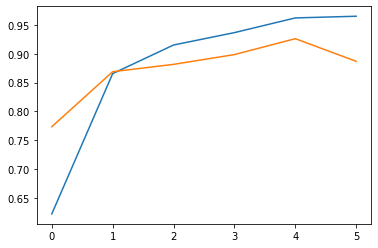

In [49]:
training_loop(
n_epochs = n_epochs,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

In [50]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
#creating a directory for the model to save in
os.mkdir('logos_model_with_none')

In [52]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), "logos_model_with_none\\logos_model_none.pth"))

In [54]:
loaded_model = get_model(n_classes=48).to(device=device)
loaded_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "logos_model_with_none\\logos_model_none.pth")))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


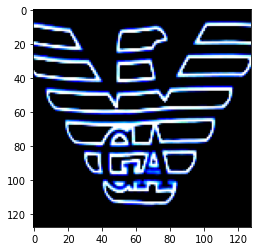

In [55]:
plt.imshow(test_data[i]["pic"].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


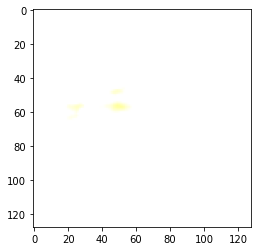

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


opel


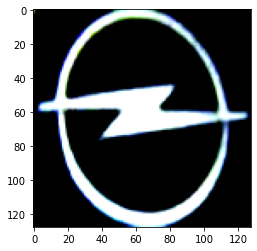

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


opel


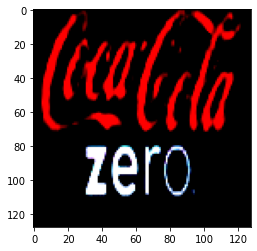

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coca cola


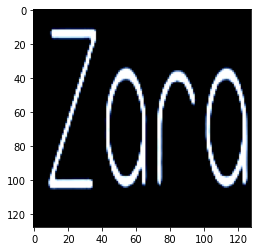

zara


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


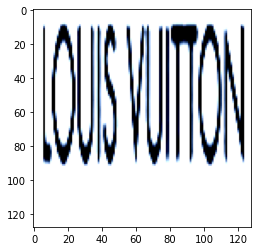

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


louis vuitton


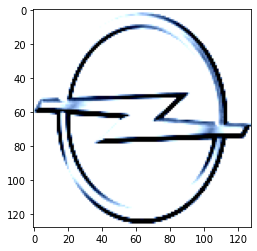

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


opel


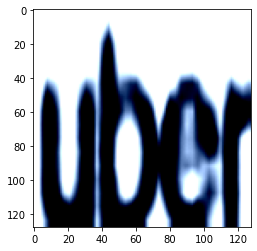

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


opel


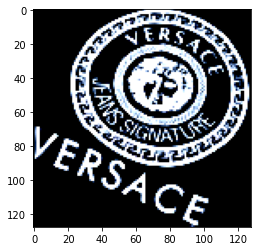

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


versace


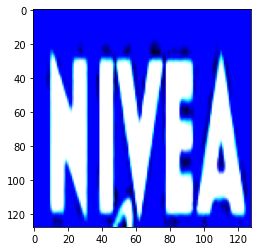

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nivea


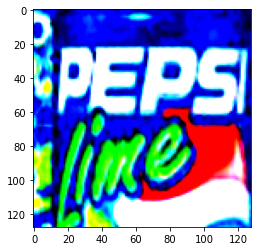

pepsi
Accuracy: 0.8766375545851528


In [73]:
pred = np.zeros(len(test_data))
true = np.zeros(len(test_data))
correct = 0
loaded_model.eval()
#attempting a few predictions
#accuracy is very low
with torch.no_grad():
    for i in range(len(test_data)):
        out = loaded_model(test_data[i]["pic"].unsqueeze(0).to(device=device))
        pred[i] = torch.argmax(out)
        true[i] = test_data[i]["label"]
        if pred[i] == true[i]:
            correct += 1
        if i < 10:
            plt.imshow(test_data[i]["pic"].permute(1, 2, 0))
            plt.show()
            print(logos.classes[int(pred[i])])
print("Accuracy:", correct/len(test_data))

In [56]:
pred

NameError: name 'pred' is not defined

In [43]:
true

array([42., 21., 43., 31., 28.,  1., 30.,  5., 40., 36.,  8., 39., 36.,
        6., 31., 31., 31., 33., 10., 40., 21., 42., 42.,  2., 41., 31.,
       40., 32.,  2.,  8., 31.,  6., 13., 11., 42., 14.,  3., 45., 46.,
       38., 17., 45.,  1., 31.,  4., 26.,  2., 33.,  2., 30., 46., 27.,
       28., 12., 36., 31., 23., 16.,  0., 40., 33., 27., 31., 35., 35.,
       34., 10., 34., 28., 37.,  8.,  2.,  6., 28., 41., 17.,  6., 32.,
        4.,  1., 26., 21., 31., 34., 44., 36., 34.,  4., 31., 28., 27.,
       43., 13., 42., 25., 34., 31., 42., 33., 22., 44., 17., 35., 34.,
       33.,  8., 17.,  0., 23., 10., 42., 42.,  3., 21.,  0., 25., 31.,
       25.,  1., 11.,  4.,  8., 12., 26.,  8., 20., 29., 35., 43., 28.,
       28.,  8., 35., 31., 33., 36., 28., 10., 27.,  6., 34.,  5., 39.,
       12., 25., 28., 33., 22., 25., 34., 45., 31., 26., 17., 34., 35.,
       45.,  2.,  4., 29., 34., 25., 17., 28.,  2.,  1., 22., 17., 12.,
       37., 20.,  9., 11., 18., 29., 19., 21., 46., 17., 26., 22

In [ ]:
len(test_data)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#create a confusion matrix from above predictions
cm = confusion_matrix(true, pred)

In [ ]:
#create an object that allows me to display the above matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = logos.classes)

In [ ]:
#displaying the confusion matrix
disp = disp.plot(cmap = "Blues", ax=plt.subplots(figsize=(20, 20))[1]) 